## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/seanyu/.conda/envs/tf18_keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [13]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 3s 59us/step - loss: 0.7606 - acc: 0.7523 - val_loss: 1.5195 - val_acc: 0.5033
Epoch 47/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.7467 - acc: 0.7576 - val_loss: 1.4950 - val_acc: 0.5015
Epoch 48/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7341 - acc: 0.7639 - val_loss: 1.5135 - val_acc: 0.5021

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.0009227448242017999.
Epoch 49/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.7204 - acc: 0.7680 - val_loss: 1.5027 - val_acc: 0.5052
Epoch 50/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.7092 - acc: 0.7723 - val_loss: 1.5085 - val_acc: 0.5084
Numbers of exp: 1, reduce_factor: 0.99, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)          

Epoch 43/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.8178 - acc: 0.7326 - val_loss: 1.4926 - val_acc: 0.5047
Epoch 44/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.8038 - acc: 0.7376 - val_loss: 1.5099 - val_acc: 0.4999
Epoch 45/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7905 - acc: 0.7421 - val_loss: 1.5022 - val_acc: 0.5017

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0008953383844345808.
Epoch 46/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.7778 - acc: 0.7490 - val_loss: 1.4988 - val_acc: 0.5041
Epoch 47/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.7630 - acc: 0.7548 - val_loss: 1.5106 - val_acc: 0.5031
Epoch 48/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.7513 - acc: 0.7582 - val_loss: 1.5200 - val_acc: 0.5036
Epoch 49/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.7382 - ac

50000/50000 [==============================] - 2s 42us/step - loss: 0.8707 - acc: 0.7115 - val_loss: 1.4720 - val_acc: 0.4929
Epoch 41/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.8571 - acc: 0.7164 - val_loss: 1.4745 - val_acc: 0.4974
Epoch 42/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8440 - acc: 0.7223 - val_loss: 1.4825 - val_acc: 0.4950
Epoch 43/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.8324 - acc: 0.7274 - val_loss: 1.4850 - val_acc: 0.4926
Epoch 44/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.8181 - acc: 0.7310 - val_loss: 1.4909 - val_acc: 0.4976
Epoch 45/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8071 - acc: 0.7349 - val_loss: 1.4971 - val_acc: 0.4931
Epoch 46/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.7927 - acc: 0.7414 - val_loss: 1.4961 - val_acc: 0.4948
Epoch 47/50
50000/50000 [=====================

Epoch 36/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.0665 - acc: 0.6364 - val_loss: 1.4302 - val_acc: 0.5073
Epoch 37/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.0647 - acc: 0.6371 - val_loss: 1.4302 - val_acc: 0.5049

Epoch 00037: ReduceLROnPlateau reducing learning rate to 2.71483095275471e-05.
Epoch 38/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.0636 - acc: 0.6373 - val_loss: 1.4300 - val_acc: 0.5081
Epoch 39/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.0618 - acc: 0.6370 - val_loss: 1.4296 - val_acc: 0.5070
Epoch 40/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.0627 - acc: 0.6379 - val_loss: 1.4295 - val_acc: 0.5078

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.357415476377355e-05.
Epoch 41/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.0608 - acc: 0.6396 - val_loss: 1.4295 - val_acc: 0.5080
Epoch 42/50

50000/50000 [==============================] - 2s 35us/step - loss: 2.5638 - acc: 0.1891 - val_loss: 2.5509 - val_acc: 0.1907
Epoch 30/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.5537 - acc: 0.1925 - val_loss: 2.5417 - val_acc: 0.1923
Epoch 31/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.5439 - acc: 0.1926 - val_loss: 2.5326 - val_acc: 0.1937
Epoch 32/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.5355 - acc: 0.1944 - val_loss: 2.5236 - val_acc: 0.1958
Epoch 33/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.5261 - acc: 0.1970 - val_loss: 2.5146 - val_acc: 0.1965
Epoch 34/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.5160 - acc: 0.1993 - val_loss: 2.5060 - val_acc: 0.1989
Epoch 35/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.5069 - acc: 0.2003 - val_loss: 2.4974 - val_acc: 0.2007
Epoch 36/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 38us/step - loss: 2.5395 - acc: 0.1742 - val_loss: 2.5189 - val_acc: 0.1856
Epoch 26/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.5291 - acc: 0.1771 - val_loss: 2.5095 - val_acc: 0.1871
Epoch 27/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.5197 - acc: 0.1793 - val_loss: 2.5000 - val_acc: 0.1903
Epoch 28/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.5101 - acc: 0.1825 - val_loss: 2.4908 - val_acc: 0.1929
Epoch 29/50
50000/50000 [==============================] - 2s 38us/step - loss: 2.5000 - acc: 0.1843 - val_loss: 2.4820 - val_acc: 0.1967
Epoch 30/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.4901 - acc: 0.1873 - val_loss: 2.4734 - val_acc: 0.1987
Epoch 31/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.4814 - acc: 0.1889 - val_loss: 2.4649 - val_acc: 0.2011
Epoch 32/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 38us/step - loss: 0.6160 - acc: 0.7879 - val_loss: 1.8235 - val_acc: 0.4568
Epoch 20/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.5839 - acc: 0.8011 - val_loss: 1.9188 - val_acc: 0.4392
Epoch 21/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5508 - acc: 0.8118 - val_loss: 1.9853 - val_acc: 0.4458

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
Epoch 22/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.5004 - acc: 0.8328 - val_loss: 1.8299 - val_acc: 0.4662
Epoch 23/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.4789 - acc: 0.8388 - val_loss: 2.1430 - val_acc: 0.4257
Epoch 24/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4447 - acc: 0.8522 - val_loss: 2.1096 - val_acc: 0.4518

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
Epoch 25/50
50000/5000

Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3385 - acc: 0.5252 - val_loss: 1.5470 - val_acc: 0.4452
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2801 - acc: 0.5460 - val_loss: 1.5600 - val_acc: 0.4518
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.2374 - acc: 0.5618 - val_loss: 1.6418 - val_acc: 0.4265
Epoch 8/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1892 - acc: 0.5795 - val_loss: 1.5060 - val_acc: 0.4560
Epoch 9/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1505 - acc: 0.5935 - val_loss: 1.4789 - val_acc: 0.4731
Epoch 10/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.1133 - acc: 0.6044 - val_loss: 1.4535 - val_acc: 0.4840
Epoch 11/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.0755 - acc: 0.6195 - val_loss: 1.5026 - val_acc: 0.4723
Epoch 12/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5574 - acc: 0.4460 - val_loss: 1.6695 - val_acc: 0.4068
Epoch 3/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4552 - acc: 0.4809 - val_loss: 1.5828 - val_acc: 0.4287
Epoch 4/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.3831 - acc: 0.5083 - val_loss: 1.6146 - val_acc: 0.4294
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3162 - acc: 0.5321 - val_loss: 1.5922 - val_acc: 0.4349
Epoch 6/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2666 - acc: 0.5511 - val_loss: 1.4607 - val_acc: 0.4796
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.2141 - acc: 0.5683 - val_loss: 1.5851 - val_acc: 0.4307
Epoch 8/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1750 - acc: 0.5830 - val_loss: 1.4555 - val_acc: 0.4844
Epoch 9/50
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 94us/step - loss: 2.9986 - acc: 0.1130 - val_loss: 2.9146 - val_acc: 0.1170
Epoch 2/50
50000/50000 [==============================] - 2s 40us/step - loss: 2.9075 - acc: 0.1209 - val_loss: 2.8465 - val_acc: 0.1267
Epoch 3/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.8486 - acc: 0.1292 - val_loss: 2.8003 - val_acc: 0.1334
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.8052 - acc: 0.1339 - val_loss: 2.7639 - val_acc: 0.1390
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.7718 - acc: 0.1401 - val_loss: 2.7345 - val_acc: 0.1425
Epoch 6/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.7434 - acc: 0.1434 - val_loss: 2.7091 - val_acc: 0.1461
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 2.7158 - acc: 0.1492 - val_loss: 2.6877 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.9516 - acc: 0.1095 - val_loss: 2.8728 - val_acc: 0.1228
Epoch 2/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.8666 - acc: 0.1205 - val_loss: 2.8084 - val_acc: 0.1355
Epoch 3/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.8114 - acc: 0.1282 - val_loss: 2.7642 - val_acc: 0.1431
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.7716 - acc: 0.1343 - val_loss: 2.7280 - val_acc: 0.1479
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.7363 - acc: 0.1400 - val_loss: 2.6981 - val_acc: 0.1536
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.7069 - acc: 0.1461 - val_loss: 2.6727 - val_acc: 0.1579
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.6827 - acc: 0.1515 - val_loss: 2.6508 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 150us/step - loss: 3.0034 - acc: 0.1034 - val_loss: 2.9234 - val_acc: 0.1184
Epoch 2/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9252 - acc: 0.1136 - val_loss: 2.8626 - val_acc: 0.1294
Epoch 3/50
50000/50000 [==============================] - 4s 82us/step - loss: 2.8719 - acc: 0.1202 - val_loss: 2.8219 - val_acc: 0.1362
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 2.8332 - acc: 0.1266 - val_loss: 2.7899 - val_acc: 0.1429
Epoch 5/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.8018 - acc: 0.1334 - val_loss: 2.7640 - val_acc: 0.1474
Epoch 6/50
50000/50000 [==============================] - 4s 78us/step - loss: 2.7754 - acc: 0.1379 - val_loss: 2.7418 - val_acc: 0.1506
Epoch 7/50
50000/50000 [==============================] - 3s 64us/step - loss: 2.7513 - acc: 0.1432 - val_loss: 2.7221 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.9848 - acc: 0.1052 - val_loss: 2.9250 - val_acc: 0.1105
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.9051 - acc: 0.1162 - val_loss: 2.8692 - val_acc: 0.1221
Epoch 3/50
50000/50000 [==============================] - 2s 40us/step - loss: 2.8567 - acc: 0.1240 - val_loss: 2.8284 - val_acc: 0.1305
Epoch 4/50
50000/50000 [==============================] - 2s 40us/step - loss: 2.8192 - acc: 0.1308 - val_loss: 2.7959 - val_acc: 0.1380
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.7898 - acc: 0.1366 - val_loss: 2.7686 - val_acc: 0.1438
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.7619 - acc: 0.1406 - val_loss: 2.7441 - val_acc: 0.1500
Epoch 7/50
50000/50000 [==============================] - 2s 43us/step - loss: 2.7394 - acc: 0.1473 - val_loss: 2.7226 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.9709 - acc: 0.1011 - val_loss: 2.9161 - val_acc: 0.1098
Epoch 2/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.8860 - acc: 0.1121 - val_loss: 2.8537 - val_acc: 0.1204
Epoch 3/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.8318 - acc: 0.1207 - val_loss: 2.8093 - val_acc: 0.1294
Epoch 4/50
50000/50000 [==============================] - 2s 40us/step - loss: 2.7899 - acc: 0.1283 - val_loss: 2.7735 - val_acc: 0.1365
Epoch 5/50
50000/50000 [==============================] - 2s 41us/step - loss: 2.7554 - acc: 0.1341 - val_loss: 2.7429 - val_acc: 0.1422
Epoch 6/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.7277 - acc: 0.1388 - val_loss: 2.7176 - val_acc: 0.1459
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.7028 - acc: 0.1440 - val_loss: 2.6938 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.8551 - acc: 0.3635 - val_loss: 4.3165 - val_acc: 0.2035
Epoch 2/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5466 - acc: 0.4532 - val_loss: 2.8856 - val_acc: 0.2332
Epoch 3/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4390 - acc: 0.4875 - val_loss: 2.1315 - val_acc: 0.3074
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.3493 - acc: 0.5223 - val_loss: 2.4226 - val_acc: 0.2594
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2749 - acc: 0.5486 - val_loss: 2.0836 - val_acc: 0.3408
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2180 - acc: 0.5686 - val_loss: 1.8175 - val_acc: 0.3977
Epoch 7/50
50000/50000 [==============================] - 2s 38us/step - loss: 1.1770 - acc: 0.5852 - val_loss: 1.7331 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.8236 - acc: 0.3711 - val_loss: 2.5865 - val_acc: 0.3027
Epoch 2/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5263 - acc: 0.4599 - val_loss: 2.4043 - val_acc: 0.3008
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.4181 - acc: 0.4984 - val_loss: 2.2241 - val_acc: 0.3351
Epoch 4/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.3403 - acc: 0.5250 - val_loss: 1.8571 - val_acc: 0.3867
Epoch 5/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2744 - acc: 0.5497 - val_loss: 2.0666 - val_acc: 0.3525
Epoch 6/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.2149 - acc: 0.5704 - val_loss: 1.6082 - val_acc: 0.4412
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.1717 - acc: 0.5853 - val_loss: 1.9879 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.8226 - acc: 0.3720 - val_loss: 2.1728 - val_acc: 0.2770
Epoch 2/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5317 - acc: 0.4601 - val_loss: 2.2801 - val_acc: 0.3094
Epoch 3/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.4205 - acc: 0.4953 - val_loss: 2.2827 - val_acc: 0.2733
Epoch 4/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.3343 - acc: 0.5269 - val_loss: 2.3735 - val_acc: 0.2841
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2826 - acc: 0.5456 - val_loss: 1.7614 - val_acc: 0.3777
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.2241 - acc: 0.5683 - val_loss: 2.2740 - val_acc: 0.3058
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.1747 - acc: 0.5873 - val_loss: 1.6864 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.8230 - acc: 0.3702 - val_loss: 2.4289 - val_acc: 0.2635
Epoch 2/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.5236 - acc: 0.4607 - val_loss: 2.6062 - val_acc: 0.2474
Epoch 3/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.4146 - acc: 0.5005 - val_loss: 1.8781 - val_acc: 0.3588
Epoch 4/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.3310 - acc: 0.5307 - val_loss: 2.5972 - val_acc: 0.2657
Epoch 5/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.2662 - acc: 0.5505 - val_loss: 2.2964 - val_acc: 0.3029
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.2084 - acc: 0.5746 - val_loss: 1.7444 - val_acc: 0.4128
Epoch 7/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.1550 - acc: 0.5936 - val_loss: 1.7984 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 164us/step - loss: 3.1005 - acc: 0.0908 - val_loss: 3.1011 - val_acc: 0.0884
Epoch 2/50
50000/50000 [==============================] - 3s 52us/step - loss: 3.0908 - acc: 0.0912 - val_loss: 3.0895 - val_acc: 0.0895
Epoch 3/50
50000/50000 [==============================] - 3s 67us/step - loss: 3.0797 - acc: 0.0926 - val_loss: 3.0787 - val_acc: 0.0902
Epoch 4/50
50000/50000 [==============================] - 3s 66us/step - loss: 3.0691 - acc: 0.0931 - val_loss: 3.0679 - val_acc: 0.0914
Epoch 5/50
50000/50000 [==============================] - 3s 54us/step - loss: 3.0584 - acc: 0.0941 - val_loss: 3.0571 - val_acc: 0.0926
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 3.0491 - acc: 0.0951 - val_loss: 3.0468 - val_acc: 0.0935
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 3.0383 - acc: 0.0957 - val_loss: 3.0365 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 179us/step - loss: 3.0367 - acc: 0.1031 - val_loss: 3.0150 - val_acc: 0.1019
Epoch 2/50
50000/50000 [==============================] - 3s 54us/step - loss: 3.0256 - acc: 0.1041 - val_loss: 3.0034 - val_acc: 0.1024
Epoch 3/50
50000/50000 [==============================] - 3s 57us/step - loss: 3.0150 - acc: 0.1054 - val_loss: 2.9924 - val_acc: 0.1040
Epoch 4/50
50000/50000 [==============================] - 3s 56us/step - loss: 3.0040 - acc: 0.1063 - val_loss: 2.9814 - val_acc: 0.1059
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.9945 - acc: 0.1068 - val_loss: 2.9708 - val_acc: 0.1072
Epoch 6/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.9842 - acc: 0.1084 - val_loss: 2.9604 - val_acc: 0.1083
Epoch 7/50
50000/50000 [==============================] - 3s 58us/step - loss: 2.9741 - acc: 0.1086 - val_loss: 2.9502 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 188us/step - loss: 3.1090 - acc: 0.0976 - val_loss: 3.1018 - val_acc: 0.1020
Epoch 2/50
50000/50000 [==============================] - 2s 50us/step - loss: 3.0973 - acc: 0.0985 - val_loss: 3.0899 - val_acc: 0.1037
Epoch 3/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.0863 - acc: 0.0992 - val_loss: 3.0788 - val_acc: 0.1059
Epoch 4/50
50000/50000 [==============================] - 3s 63us/step - loss: 3.0758 - acc: 0.1008 - val_loss: 3.0676 - val_acc: 0.1086
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 3.0645 - acc: 0.1018 - val_loss: 3.0572 - val_acc: 0.1093
Epoch 6/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.0543 - acc: 0.1026 - val_loss: 3.0468 - val_acc: 0.1112
Epoch 7/50
50000/50000 [==============================] - 4s 74us/step - loss: 3.0448 - acc: 0.1038 - val_loss: 3.0366 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 190us/step - loss: 3.0770 - acc: 0.0948 - val_loss: 3.0538 - val_acc: 0.0982
Epoch 2/50
50000/50000 [==============================] - 3s 58us/step - loss: 3.0661 - acc: 0.0951 - val_loss: 3.0432 - val_acc: 0.0991
Epoch 3/50
50000/50000 [==============================] - 4s 77us/step - loss: 3.0573 - acc: 0.0965 - val_loss: 3.0332 - val_acc: 0.1009
Epoch 4/50
50000/50000 [==============================] - 3s 62us/step - loss: 3.0458 - acc: 0.0978 - val_loss: 3.0233 - val_acc: 0.1019
Epoch 5/50
50000/50000 [==============================] - 3s 56us/step - loss: 3.0381 - acc: 0.0988 - val_loss: 3.0136 - val_acc: 0.1035
Epoch 6/50
50000/50000 [==============================] - 3s 63us/step - loss: 3.0278 - acc: 0.1010 - val_loss: 3.0043 - val_acc: 0.1045
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 3.0188 - acc: 0.1004 - val_loss: 2.9948 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 205us/step - loss: 3.0817 - acc: 0.0996 - val_loss: 3.0676 - val_acc: 0.0974
Epoch 2/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.0709 - acc: 0.1016 - val_loss: 3.0555 - val_acc: 0.0984
Epoch 3/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.0599 - acc: 0.1016 - val_loss: 3.0440 - val_acc: 0.0994
Epoch 4/50
50000/50000 [==============================] - 3s 56us/step - loss: 3.0500 - acc: 0.1032 - val_loss: 3.0329 - val_acc: 0.1007
Epoch 5/50
50000/50000 [==============================] - 3s 59us/step - loss: 3.0395 - acc: 0.1044 - val_loss: 3.0223 - val_acc: 0.1019
Epoch 6/50
50000/50000 [==============================] - 3s 55us/step - loss: 3.0304 - acc: 0.1052 - val_loss: 3.0119 - val_acc: 0.1032
Epoch 7/50
50000/50000 [==============================] - 3s 54us/step - loss: 3.0204 - acc: 0.1067 - val_loss: 3.0020 - val_a

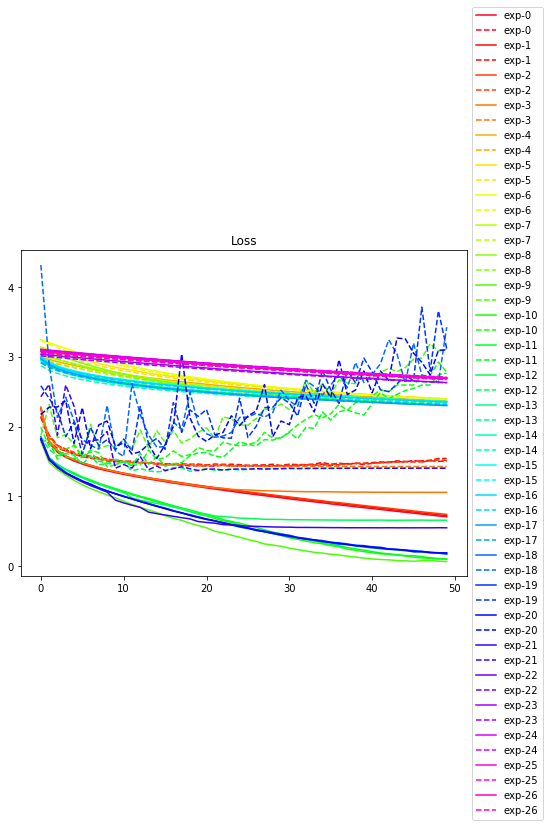

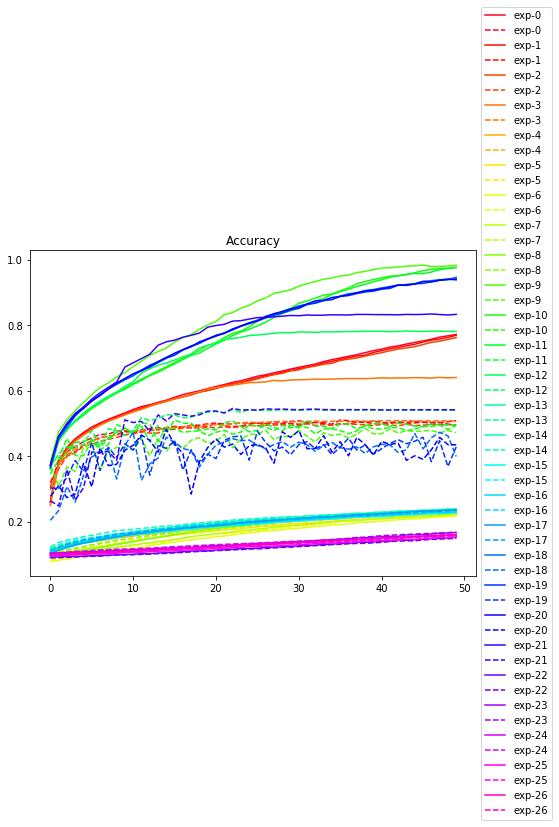

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()